Populating the interactive namespace from numpy and matplotlib


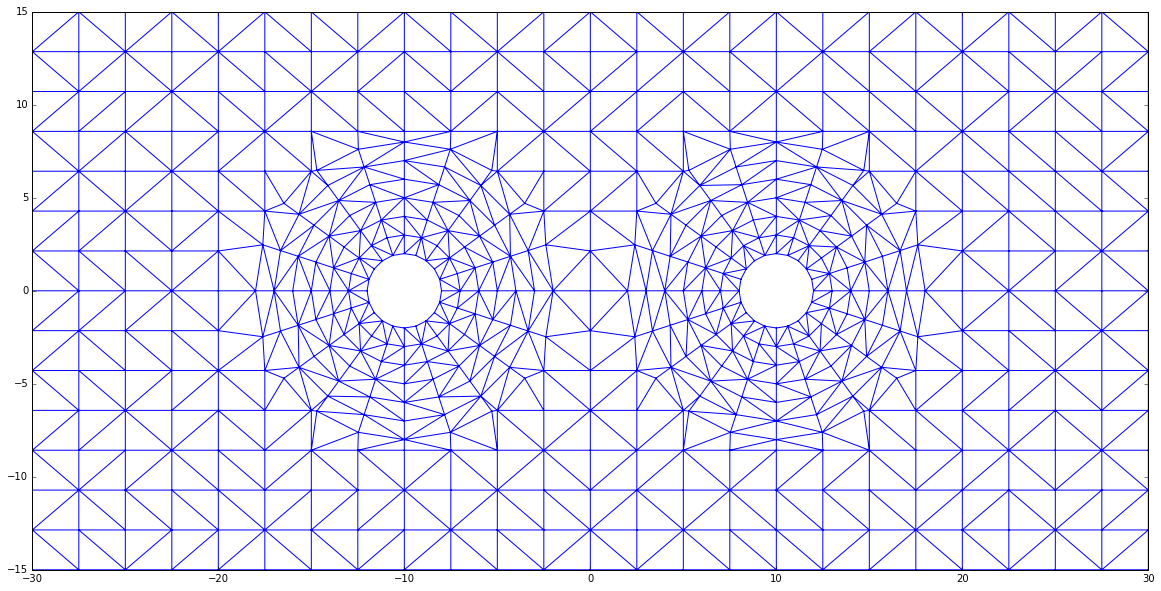

In [1]:
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%pylab inline
pylab.rcParams['figure.figsize']=(20,10)

R=2
cntr1 = -10
cntr2 = 10
def get_radius(r,cntr):
    n_pts = 10
    step = 180/n_pts
    pts = []
    for i in range(n_pts+1):
        y =  r*np.cos(np.pi*i*step/180)
        x =  r*np.sin(np.pi*i*step/180)
        pts.append([x+cntr, y])
        pts.append([-x+cntr, y])
    return pts

def not_in_ring(pts, cntr):
    return (pts[0]-cntr)**2+(pts[1])**2 >= R**2

points = []
for r in range(R,R+7,1):
    points.extend(get_radius(r, cntr1))
    
for r in range(R,R+7,1):
    points.extend(get_radius(r, cntr2))

x = np.linspace(-30,30,25)
y = np.linspace(-15,15,15)
for i in range(25):
    for j in range(15):
        if (x[i]-cntr1)**2+(y[j])**2 > (R+6)**2 and\
           (x[i]-cntr2)**2+(y[j])**2 > (R+6)**2 :
                points.append([x[i],y[j]])
    
points = np.array(points)
tri = Delaunay(points)

index2point = lambda index: tri.points[index]
all_centers = index2point(tri.simplices)
outside = [not_in_ring(item.mean(axis=0), cntr1) & not_in_ring(item.mean(axis=0), cntr2) for item in all_centers]

plt.triplot(points[:,0], points[:,1], tri.simplices[where(outside)])
plt.show()


In [ ]:
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from scipy.interpolate import LinearNDInterpolator

def get_area(ind):
    pt1, pt2, pt3 = index2point(tri.simplices[ind])
    return abs(0.5*cross(pt2-pt1,pt3-pt1))

def get_center(ind):
    return index2point(tri.simplices[ind]).mean(axis=0)

def get_len(pt1, pt2):
    return np.linalg.norm(pt2-pt1)

def get_edge(ind1, ind2):
    pts=[]
    for i in range(3):
        for j in range(3):
            if tri.simplices[ind1][i] == tri.simplices[ind2][j]:
                pts.append(tri.simplices[ind1][i])
    return index2point(pts)

def get_norm(a, e):
    if a[1]*e[0]-a[0]*e[1] > 0:
        return np.array([a[1], -a[0]])
    
    return np.array([-a[1], a[0]])

In [ ]:
A = lil_matrix((len(tri.simplices), len(tri.simplices)))
b = zeros(len(tri.simplices))
for i in range(len(tri.simplices)):
    if ~outside[i]: 
        A[i,i] = 1
        continue
    
    cnt = get_center(i)
     
    for j in range(3):
        nei = tri.neighbors[i][j]
        #border
        if nei == -1:
            continue
        
        #electrode
        elif ~outside[nei]:
            #left or right
            if cnt[0]<0:
                b[i] -= 5*val
            else:
                b[i] += 5*val
                
            A[i,i] -= val
            
            continue
        
        #internal cell
        else:
            
            A[i,i] -= val
            A[i,nei] += val

sltn_v=spsolve(A,b)
solution=LinearNDInterpolator(np.array([item.mean(axis=0) for item in all_centers]),sltn_v)
X,Y=mgrid[-30:30,-15:15]
plt.imshow(solution(-X,Y).T)
